### Setup

In [44]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tsfel
import os
import pickle as pkl
import seaborn as sns
from scipy.stats import kurtosis, skew
import math

# Constants
time = 10
offset = 100
folders = ["LAYING","SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIRS"]
classes = {"WALKING":1,"WALKING_UPSTAIRS":2,"WALKING_DOWNSTAIRS":3,"SITTING":4,"STANDING":5,"LAYING":6}

dir = os.path.join("./HAR/Wild Data")

X = []
y = []

for folder in folders:
    files = os.listdir(os.path.join(dir,folder))

    for file in files:

        df = pd.read_csv(os.path.join(dir,folder,file),sep=",",header=0)
        df = df[offset:offset+time*50]
        X.append(df.values)
        y.append(classes[folder])

X = np.array(X)
y = np.array(y)

print("Wild data shape: ",X.shape)

Wild data shape:  (18, 500, 3)


### Decision Tree trained on Raw Acceleration Data

Raw Accelerometer Data Shape (18, 500, 3)
Accuracy of raw acc. data: 0.1111
precision: 0.6905
recall: 0.1111


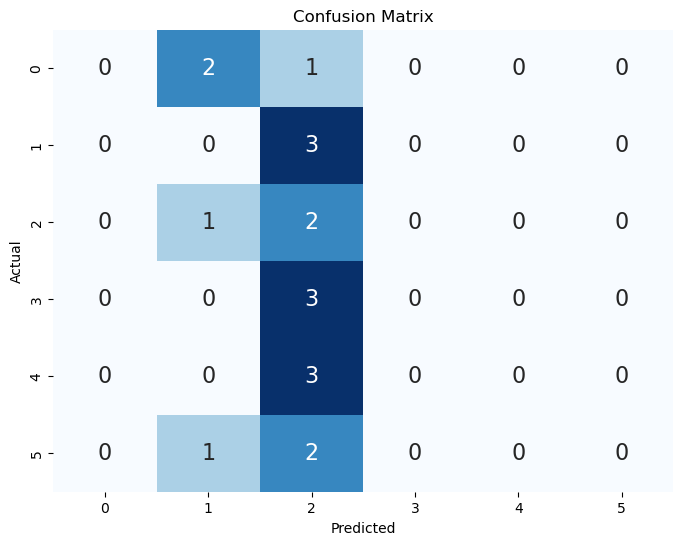

In [19]:
seed = 4

X_raw  = np.square(X[:, :, 0])+np.square(X[:, :, 1])+np.square(X[:, :, 2])

X_raw = pd.DataFrame(np.sqrt(X_raw))

print("Raw Accelerometer Data Shape",X.shape)

raw_clf = pkl.load(open("HAR/Models/raw_clf.pkl",'rb'))

y_raw_pred = raw_clf.predict(X_raw)

accuracy = accuracy_score(y, y_raw_pred)
precision = precision_score(y, y_raw_pred, average='weighted',zero_division=1)
recall = recall_score(y, y_raw_pred, average='weighted')
cm = confusion_matrix(y, y_raw_pred)

print(f"Accuracy of raw acc. data: {accuracy:<.4f}")
print(f"precision: {precision:<.4f}")
print(f"recall: {recall:<.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

### Decision Tree trained on Featurised Acceleration Data

In [36]:
def extract_row_features(row, cfg):
    return tsfel.time_series_features_extractor(cfg, row)

def extract_features(df, cfg):
    features_list = []
    for i in range(df.shape[0]):
        row_features = extract_row_features(df.iloc[i], cfg)
        features_list.append(row_features)
    features_df = pd.concat(features_list, ignore_index=True)
    return features_df

def compute_features(row):
    x = np.array(row)
    features = {
        'Max': np.max(x),
        'Min': np.min(x),
        'Mean': np.mean(x),
        'Median': np.median(x),
        'Standard Deviation': np.std(x),
        'Variance': np.var(x),
        'Kurtosis': kurtosis(x),
        'Skewness': skew(x),
        'Root Mean Square': np.sqrt(np.mean(x**2)),
    }    
    return pd.Series(features)

In [ ]:
cgf = tsfel.get_features_by_domain()

features_df = extract_features(X_raw, cgf)
features_new = X_raw.apply(compute_features, axis=1)

X_tsfel_all = pd.concat([features_df, features_new], axis=1)

tsfel_clf = pkl.load(open("HAR/Models/tsfel_clf.pkl",'rb'))

y_tsfel = tsfel_clf.predict(X_tsfel_all)

accuracy = accuracy_score(y, y_tsfel)
precision = precision_score(y, y_tsfel, average='weighted',zero_division=1)
recall = recall_score(y, y_tsfel, average='weighted')
cm = confusion_matrix(y, y_tsfel)

Accuracy of featurised acc. data: 0.1667
precision: 0.7000
recall: 0.1667


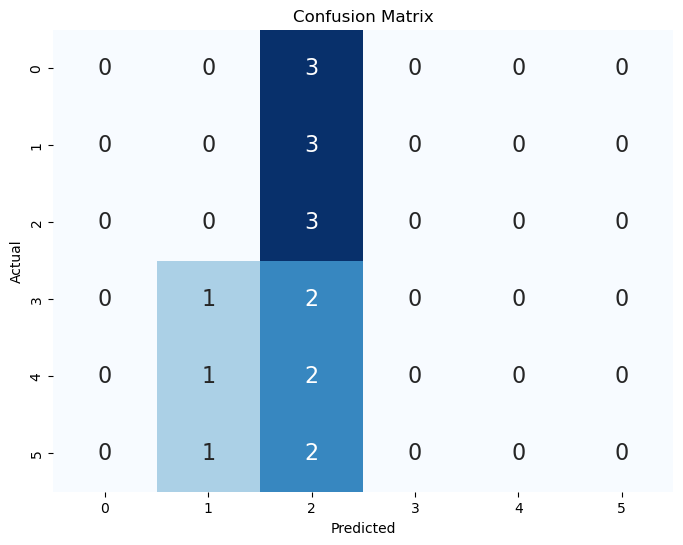

In [43]:
print(f"Accuracy of featurised acc. data: {accuracy:<.4f}")
print(f"precision: {precision:<.4f}")
print(f"recall: {recall:<.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In both the cases with Decision tree trained on Raw acceleration data and Decision tree trained on Featurized acceleration data, the models perform very poorly with low accuracies.

### Few shot with UCI Dataset

In [52]:
from langchain_groq.chat_models import ChatGroq

# Available Models
groq_models = {
    "llama3-70b": "llama3-70b-8192",
    "gemma-7b": "gemma-7b-it",
    "llama3.1-70b":"llama-3.1-70b-versatile",
    "llama3-8b":"llama3-8b-8192"
    }
model = groq_models["llama3-70b"]

# Constants
GROQ_API_KEY = os.environ.get("GROQ_API_KEY")
green = "\x1b[32;40m"
red =   "\x1b[31;40m"
reset = "\x1b[0m"       # color reset
classes = {"WALKING":1,"WALKING_UPSTAIRS":2,"WALKING_DOWNSTAIRS":3,"SITTING":4,"STANDING":5,"LAYING":6}
folders = list(classes.keys())

X_train = np.loadtxt("./HAR/UCI HAR Dataset/train/X_train.txt")
y_train = np.loadtxt("./HAR/UCI HAR Dataset/train/y_train.txt",dtype=np.int32)
X_test = X_tsfel_all
y_test = y

features = pd.read_csv("./HAR/UCI HAR Dataset/features.txt",sep="\s+",header=None)[1]

X_train = pd.DataFrame(X_train,columns=features)

print("Testing Data Shape",X_test.shape)

X_examples = []
y_examples = []

for i in range(len(X_train)):
    if y_train[i] not in y_examples:
        X_examples.append(X_train.iloc[i,:])
        y_examples.append(y_train[i])

examples = "\n".join([f"EXAMPLE {i} DATA :\n{X_examples[i]}\nEXAMPLE {i} LABEL : {folders[y_examples[i]-1]}" for i in range(len(X_examples))])

few_shot_prompt = lambda data:f"""
* You are HAR tool.
* Your task is to analyze the provided labeled featurised 3-axis accelerometer data and learn the patterns associated with the label in order to identify unlabeled data.
* Only give output in one word and do not provide any explanation.
{examples}

TEST DATA: {data}
LABEL for TEST DATA: ?
"""

Testing Data Shape (18, 393)


In [53]:
few_shot_correct_count = 0

llm = ChatGroq(model=model, api_key=GROQ_API_KEY, temperature=0)
few_shot_ans = []

for i in range(len(X_test)):

    query = few_shot_prompt(X_test.loc[i,:])
    ans = llm.invoke(query).content
    few_shot_ans.append(ans)
    
    if(ans==folders[y_test[i]-1]):
        few_shot_correct_count+=1
        color = green
    else:
        color = red
    few_shot_ans.append(ans)
    
    print(f"\r{model:<15}: Test case #{i:<3} Output: {color}{ans:<18} {reset}Actual: {folders[y_test[i]-1]:<20} Correct:{few_shot_correct_count}",end="")

print()
print(f"""
Model:               {model}
Total Test Cases:    {len(X_test)}
Correct Predictions: {few_shot_correct_count}
Accuracy:            {few_shot_correct_count/(len(X_test)):.2f}
""")

llama3-70b-8192: Test case #17  Output: WALKING            Actual: WALKING_UPSTAIRS     Correct:3

Model:               llama3-70b-8192
Total Test Cases:    18
Correct Predictions: 3
Accuracy:            0.17



### Few Shot with Wild Data

In [62]:
# split the data into training and testing sets. Change the seed value to obtain different random splits.
seed = 100
X_train,X_test,y_train,y_test = train_test_split(X_tsfel_all,y,test_size=0.3,random_state=seed,stratify=y)

print("Training Data Shape",X_train.shape)
print("Testing Data Shape",X_test.shape)

X_examples = []
y_examples = []

for i in range(len(X_train)):
    if y_train[i] not in y_examples:
        X_examples.append(X_train.iloc[i,:])
        y_examples.append(y_train[i])

examples = "\n".join([f"EXAMPLE {i} DATA :\n{X_examples[i]}\nEXAMPLE {i} LABEL : {folders[y_examples[i]-1]}" for i in range(len(X_examples))])

few_shot_prompt = lambda data:f"""
* You are HAR tool.
* Your task is to analyze the provided labeled featurised 3-axis accelerometer data and learn the patterns associated with the label in order to identify unlabeled data.
* Only give output in one word and do not provide any explanation.
{examples}

TEST DATA: {data}
LABEL for TEST DATA: ?
"""

Training Data Shape (12, 393)
Testing Data Shape (6, 393)


In [63]:
few_shot_correct_count = 0

llm = ChatGroq(model=model, api_key=GROQ_API_KEY, temperature=0)
few_shot_ans = []

for i in range(len(X_test)):

    query = few_shot_prompt(X_test.iloc[i,:])
    ans = llm.invoke(query).content
    few_shot_ans.append(ans)
    
    if(ans==folders[y_test[i]-1]):
        few_shot_correct_count+=1
        color = green
    else:
        color = red
    few_shot_ans.append(ans)

    print(f"\r{model:<15}: Test case #{i:<3} Output: {color}{ans:<18} {reset}Actual: {folders[y_test[i]-1]:<20} Correct:{few_shot_correct_count}",end="")

print()
print(f"""
Model:               {model}
Total Test Cases:    {len(X_test)}
Correct Predictions: {few_shot_correct_count}
Accuracy:            {few_shot_correct_count/(len(X_test)):.2f}
""")

llama3-70b-8192: Test case #5   Output: WALKING            Actual: WALKING_DOWNSTAIRS   Correct:3

Model:               llama3-70b-8192
Total Test Cases:    6
Correct Predictions: 3
Accuracy:            0.50

